In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
directory = 'slurm/data/20241104_203226'

In [3]:
with open(f'{directory}/config.json', 'r') as f:
    config = json.load(f)

In [4]:
data_by_config = {}

for file in os.listdir(f'{directory}/output/'):
    data = json.load(open(f'{directory}/output/{file}', 'r'))
    config_idx = int(file.split('_')[1])
    data_by_config[config_idx] = data

In [5]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            return idx
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

In [6]:
sliding_data = get_data(config, data_by_config, 'regular_t_1000_0', {'scheduling_method':'sliding', 'speculation_accuracy':0})

In [7]:
sliding_data['decoding_data']['completed_windows_by_round'][-1]

40369

In [8]:
len(sliding_data['decoding_data']['window_decoding_start_times'])

40369

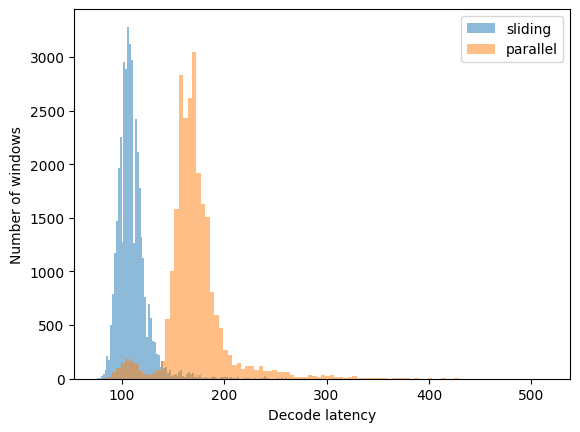

In [9]:
sliding_data = get_data(config, data_by_config, 'regular_t_1000_0', {'scheduling_method':'sliding', 'speculation_accuracy':0})

decode_latencies = []
for window_idx, decode_start in sliding_data['decoding_data']['window_decoding_start_times'].items():
    completion_time = sliding_data['decoding_data']['window_decoding_completion_times'][window_idx]
    decode_latencies.append(completion_time - decode_start + 1)
plt.hist(decode_latencies, bins=100, alpha=0.5, label='sliding')

sliding_data = get_data(config, data_by_config, 'regular_t_1000_0', {'scheduling_method':'parallel', 'speculation_accuracy':0})

decode_latencies = []
for window_idx, decode_start in sliding_data['decoding_data']['window_decoding_start_times'].items():
    completion_time = sliding_data['decoding_data']['window_decoding_completion_times'][window_idx]
    decode_latencies.append(completion_time - decode_start + 1)
plt.hist(decode_latencies, bins=100, alpha=0.5, label='parallel')

plt.ylabel('Number of windows')
plt.xlabel('Decode latency')
plt.legend()
plt.show()

In [10]:
get_config_idx(config, 'regular_t_1000_0', {'scheduling_method':'sliding', 'speculation_accuracy': 0}), get_config_idx(config, 'regular_t_1000_0', {'scheduling_method':'sliding', 'speculation_accuracy': 0.99})

(5, 38)

In [11]:
hatches = ['', '//', '+', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [12]:
def plot_data(data_by_config, config, group_by: str, group_by_2: str, device_or_decode: str):
    benchmarks = []
    group_keys = []
    group_keys_2 = []
    results = {}
    for key, data in data_by_config.items():
        benchmark = benchmark_name(config[key])
        if device_or_decode == 'device':
            runtime = data['device_data']['num_rounds']
        else:
            runtime = data['decoding_data']['num_rounds']
        group_key = config[key][group_by]
        group_key_2 = config[key][group_by_2]
        benchmarks.append(benchmark)
        group_keys.append(group_key)
        group_keys_2.append(group_key_2)
        results[(benchmark, group_key, group_key_2)] = runtime
    
    # sort benchmarks and group keys by average 
    benchmark_avgs = {b:np.mean([r for (bench,_,_),r in results.items() if bench == b]) for b in set(benchmarks)}
    key_avgs = {k:np.mean([r for (_,key,_),r in results.items() if key == k]) for k in set(group_keys)}
    key_2_avgs = {k:np.mean([r for (_,_,key),r in results.items() if key == k]) for k in set(group_keys_2)}
    sorted_benchmarks = sorted(benchmark_avgs, key=lambda x: benchmark_avgs[x])
    sorted_keys = sorted(key_avgs, key=lambda x: key_avgs[x])
    sorted_keys_2 = sorted(key_2_avgs, key=lambda x: key_2_avgs[x], reverse=True)

    print(sorted_keys)
    print(sorted_keys_2)

    fig,ax = plt.subplots()
    centers = []
    for i,benchmark in enumerate(sorted_benchmarks):
        center = i*(len(sorted_keys)+len(sorted_keys_2)+2) + (len(sorted_keys)+len(sorted_keys_2))/2
        centers.append(center)
        for j,key in enumerate(sorted_keys):
            for k,key_2 in enumerate(sorted_keys_2):
                try:
                    x = i*(len(sorted_keys)+len(sorted_keys_2)+2) + j*(len(sorted_keys_2)) + k
                    ax.bar(x, results[(benchmark,key,key_2)], color=f'C{j}', width=1, hatch=hatches[k], edgecolor='k', label=f'{group_by}={key}, {group_by_2}={key_2}' if i == 0 else None)
                except:
                    print(f'No data for {benchmark} and {key} (config idx {get_config_idx(config, benchmark, {group_by:key})})')
    ax.set_xticks(centers, sorted_benchmarks, rotation=45, ha='right')
    return ax, results

['sliding', 'parallel', 'aligned']
[0, 0.99]
No data for qrom_15_15 and aligned (config idx 28)
No data for qrom_15_15 and aligned (config idx 28)
No data for carleman_encoding_2_4 and aligned (config idx 30)
No data for carleman_encoding_2_4 and aligned (config idx 30)


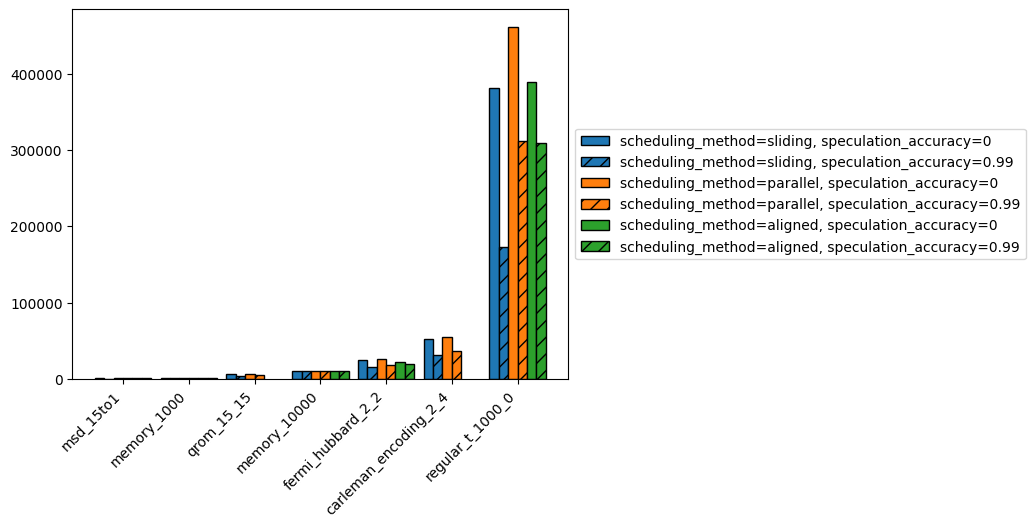

In [13]:
ax, results = plot_data(data_by_config, config, 'scheduling_method', 'speculation_accuracy', 'device')

# plt.yscale('log')
# legend outside on right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [15]:
with open(f'{directory}/decoder_dists.json', 'r') as f:
    decoder_dists = json.load(f)

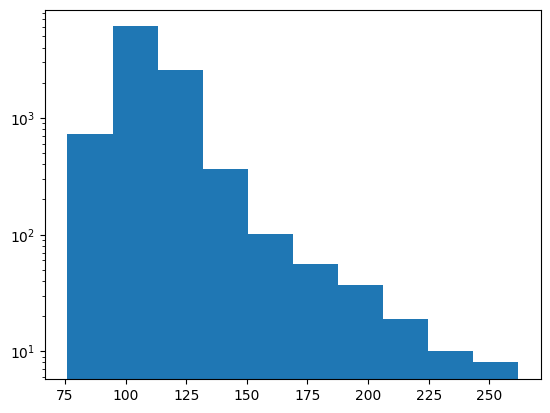

In [16]:
plt.hist(decoder_dists['21']['2'])
plt.yscale('log')